# _Проект №3. О вкусной и здоровой пище_


# Основная информация

**Predict TripAdvisor Rating Andrew Glybin (SF_DST)**

## Цель проекта 

**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   



### Предоставленное описание датасета

* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана



## Этапы выполнения проекта

1. Загрузка и первичный отсмотр данных.
2. Проверка и анализ имеющихся признаков.
3. Создание и отбор признаков, выбор формы модели.
4. Коррелляционный анализ, наличие выбросов и аномалий.
5. Создание модели, работающей на алгоритме машинного обучения, для предсказания целевого признака.
6. Оценка качества работы модели и другие итоги работы.


# import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np    # linear algebra
import pandas as pd   # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas_profiling

import ast
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from collections import Counter
import itertools

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [4]:
# зафиксируем общую текущую дату
CURRENT_DATE = pd.to_datetime('11/09/2020')

# DATA

In [5]:
# DATA_DIR = '/data/'
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
sample_submission = pd.read_csv('sample_submission.csv')

cities = pd.read_csv('worldcities.csv')

In [6]:
df_train.head(1)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [8]:
df_train.nunique()

Restaurant_id        11909
City                    31
Cuisine Style         9007
Ranking              11936
Rating                   9
Price Range              3
Number of Reviews     1459
Reviews              33516
URL_TA               39980
ID_TA                39980
dtype: int64

In [9]:
df_test.head(1)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918


In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


Из анализа сетов и количества уникальных значений можно сделать следующие выводы:
- Restaurant_id  не является уникальным идентификатором ресторана
- только 3 признака являются числовыми
- в тестовом сете отсутствует признак Rating, т.к. именно его нам нужно предсказать
- на роль уникального идентификатора претендует признак ID_TA                

In [11]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет

df_train['sample'] = 1   # помечаем где у нас трейн
df_test['sample'] = 0    # помечаем где у нас тест
df_test['Rating'] = 0    # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True)   # объединяем

# FUNCTION

In [14]:
def is_capital(city):
    '''
    Определяет входит ли город в множество столиц
    
    '''
    
    return city in capitals


In [15]:
def list_unzip(list_of_lists):
    '''
    Преобразование признака в список встречающихся значений
    
    '''
    
    result=[]
    for lst in list_of_lists:
        result.extend(lst)
    return result


In [12]:
def get_list(list_string):
    '''
    Перевод строковых представлений списков с помощью модуля AST
    
    '''
    
    result_list = ast.literal_eval(list_string)
    return result_list


In [13]:
def default_changes(list_string):
    '''
    Замена nan в строковых представлениях списков отзывов и их дат на строку 
    с датой по-умолчанию '01/01/2000', а также замена пустого список вида [] 
    на список с незаполненными элементами вида ['01/01/2000', '01/01/2000']
    
    '''
    
    if type(list_string) == float:
        return "[['review1', 'review2'], ['01/01/2000', '01/01/2000']]"
    list_string = list_string.replace('[nan', "['01/01/2000'")
    list_string = list_string.replace('nan]', "'01/01/2000']")
    list_string = list_string.replace('[]', "['01/01/2000', '01/01/2000']")
    return list_string


In [ ]:
def get_days(timedelta):
    '''
    Приведение типа данных timedelta64 к типу данных int64
    
    '''
    
    return timedelta.days


In [90]:
def round_rating(x):
    '''
    Огругление прогнозируемого рейтинга с шагом 0.5
    
    '''
    return (round(x*2.0)/2)


In [81]:
def preproc_data(df_input):
    '''
    Подготовка датасета для обучения.
    Можно включить сюда всю предварительную обработку датасета.
    
    '''
    
    df_output = df_input.copy()
    
    # убираем не нужные для модели признаки
    df_output.drop(['URL_TA', 'Last_Date', 'First_Date'], axis = 1, inplace=True)
        
    # обрпботка пропуском в соответствии с выбранными гипотезами
    # тут ваш код по обработке NAN
    # ....
    
    # для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
    # также можно использовать другие варианты из библиотеки sklearn.preprocessing, например, LabelEncoder 
    # тут ваш код по Encoding 
    # ....
        
    # необходима генерация дополнительных признаков и внедрение внешней информации
    # тут ваш код не генерацию новых фитчей
    # ....
        
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis = 1, inplace=True)
    
    return df_output


# PREPROC

### Предварительный анализ данных

In [16]:
pandas_profiling.ProfileReport(df_train)

D:\Anaconda3\lib\site-packages\pandas_profiling\describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,11
Number of observations,40000
Total Missing (%),5.8%
Total size in memory,3.4 MiB
Average record size in memory,88.0 B
Numeric,3
Categorical,7
Boolean,0
Date,0
Text (Unique),0
Rejected,1


In [17]:
# Какой список городов имеется в нашем датасете?

data['City'].value_counts()

London        7193
Paris         6108
Madrid        3813
Barcelona     3395
Berlin        2705
Milan         2694
Rome          2589
Prague        1816
Lisbon        1647
Vienna        1443
Amsterdam     1372
Brussels      1314
Hamburg       1186
Munich        1145
Lyon          1126
Stockholm     1033
Budapest      1021
Warsaw         925
Dublin         836
Copenhagen     819
Athens         776
Edinburgh      745
Zurich         685
Oporto         642
Geneva         590
Krakow         554
Oslo           488
Helsinki       475
Bratislava     380
Luxembourg     263
Ljubljana      222
Name: City, dtype: int64

In [18]:
# У нас есть справочник всех городов мира. Посмотрим его.

cities

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Tokyo,Tokyo,35.6850,139.7514,Japan,JP,JPN,Tōkyō,primary,35676000.0,1392685764
1,New York,New York,40.6943,-73.9249,United States,US,USA,New York,NaN,19354922.0,1840034016
2,Mexico City,Mexico City,19.4424,-99.1310,Mexico,MX,MEX,Ciudad de México,primary,19028000.0,1484247881
3,Mumbai,Mumbai,19.0170,72.8570,India,IN,IND,Mahārāshtra,admin,18978000.0,1356226629
4,São Paulo,Sao Paulo,-23.5587,-46.6250,Brazil,BR,BRA,São Paulo,admin,18845000.0,1076532519
...,...,...,...,...,...,...,...,...,...,...,...
15488,Timmiarmiut,Timmiarmiut,62.5333,-42.2167,Greenland,GL,GRL,Kujalleq,NaN,10.0,1304206491
15489,Cheremoshna,Cheremoshna,51.3894,30.0989,Ukraine,UA,UKR,Kyyivs’ka Oblast’,NaN,0.0,1804043438
15490,Ambarchik,Ambarchik,69.6510,162.3336,Russia,RU,RUS,Sakha (Yakutiya),NaN,0.0,1643739159
15491,Nordvik,Nordvik,74.0165,111.5100,Russia,RU,RUS,Krasnoyarskiy Kray,NaN,0.0,1643587468


In [20]:
cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15493 entries, 0 to 15492
Data columns (total 11 columns):
city          15493 non-null object
city_ascii    15493 non-null object
lat           15493 non-null float64
lng           15493 non-null float64
country       15493 non-null object
iso2          15462 non-null object
iso3          15493 non-null object
admin_name    15302 non-null object
capital       5246 non-null object
population    13808 non-null float64
id            15493 non-null int64
dtypes: float64(3), int64(1), object(7)
memory usage: 1.3+ MB


In [19]:
# Среди всех городов тестового датасета есть только один неизвестный даже полному справочнику городов мира

cities[cities['city_ascii'] == 'Oporto']

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id


In [21]:
# Предположительно в тестовый датасет вкралась случайная ошибка. Исправим её.

data.replace('Oporto', 'Porto', inplace=True)

In [22]:
# Оставим в справочнике городов для нужд проекта только города с населением выше среднего

cities = cities[cities['population'] > 107000.0]

In [23]:
# Уберём дубликаты названий крупных городов в неоригинальных странах в целях избежания ошибки

cities = cities[~((cities['city'].isin(['Barcelona', 'Athens', 'London'])) & (cities['iso3'].isin(['VEN', 'USA', 'CAN'])))]

In [24]:
cities.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3104 entries, 0 to 3140
Data columns (total 11 columns):
city          3104 non-null object
city_ascii    3104 non-null object
lat           3104 non-null float64
lng           3104 non-null float64
country       3104 non-null object
iso2          3103 non-null object
iso3          3104 non-null object
admin_name    3078 non-null object
capital       1925 non-null object
population    3104 non-null float64
id            3104 non-null int64
dtypes: float64(3), int64(1), object(7)
memory usage: 291.0+ KB


### Посмотрим распределение признака 'Ranking'

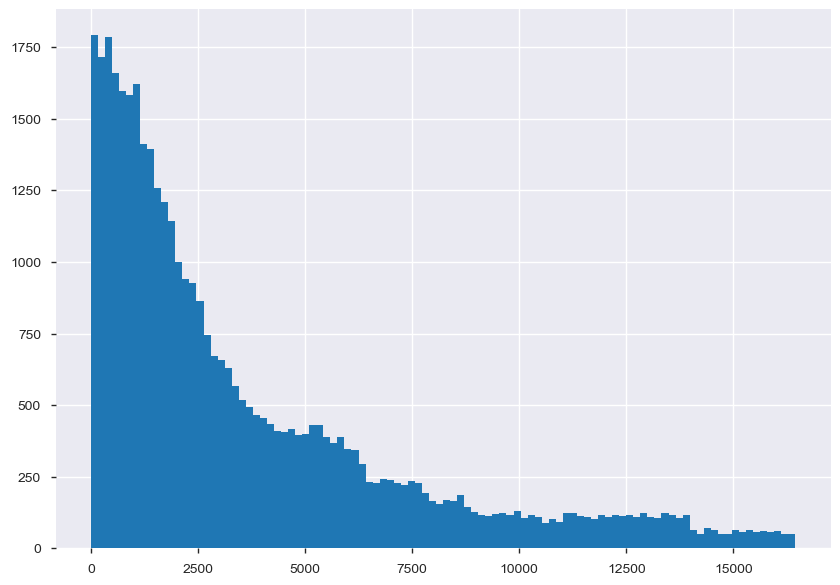

In [25]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

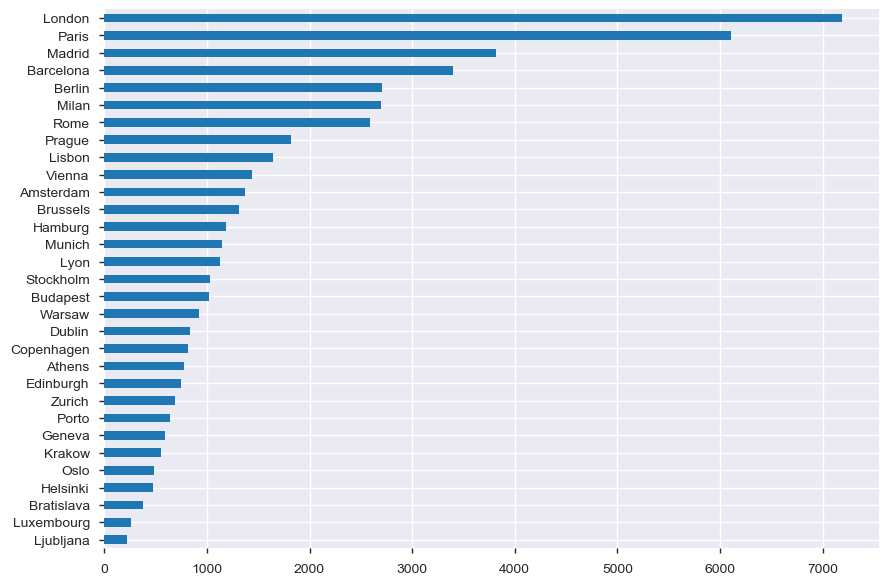

In [26]:
data['City'].value_counts(ascending=True).plot(kind='barh')

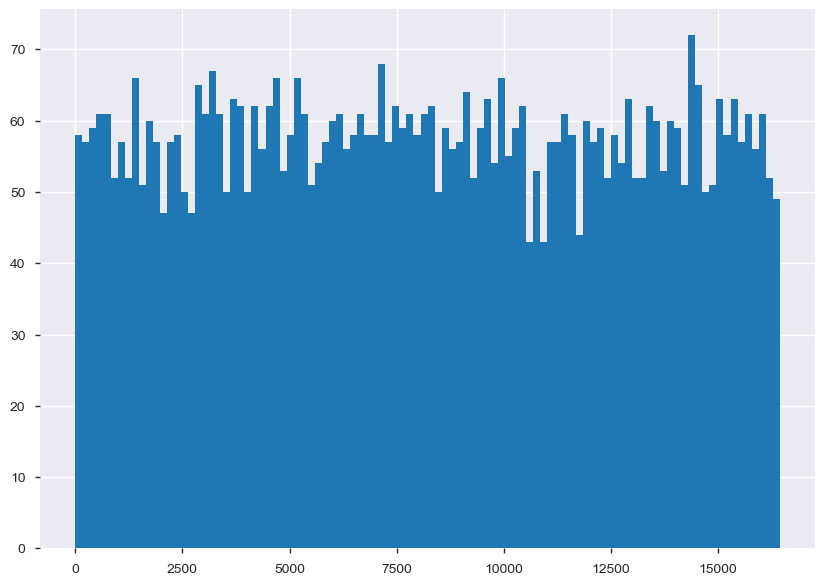

In [27]:
# распределение в самом большом по еоличеству ресторанов городе

df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

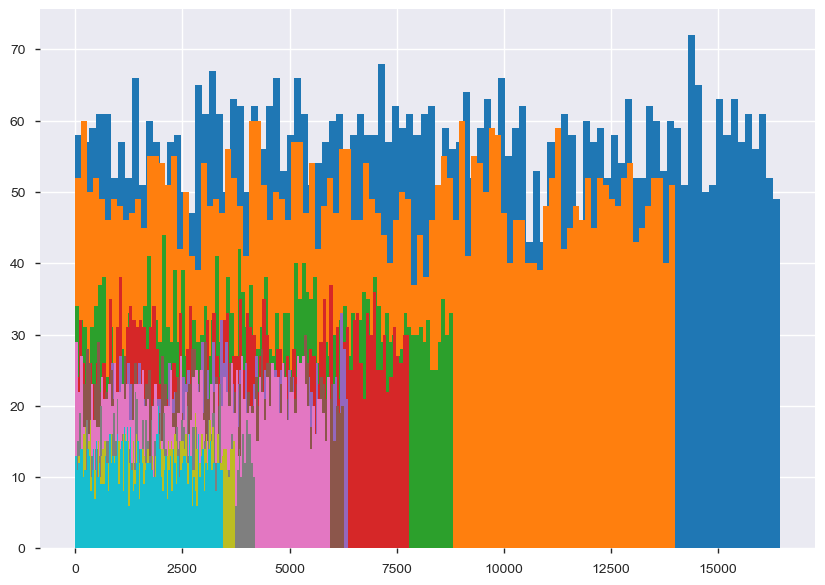

In [28]:
# посмотрим на топ 10 городов

for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()


### Распределение целевой переменной

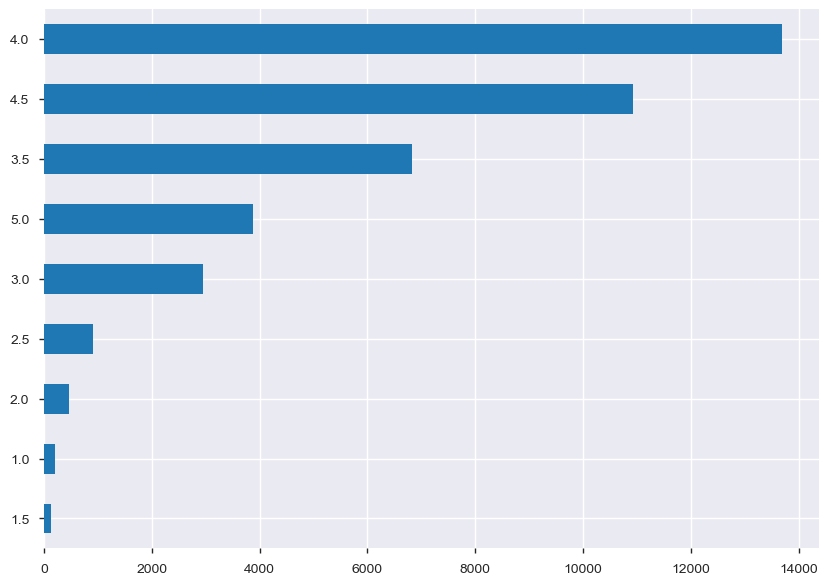

In [29]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

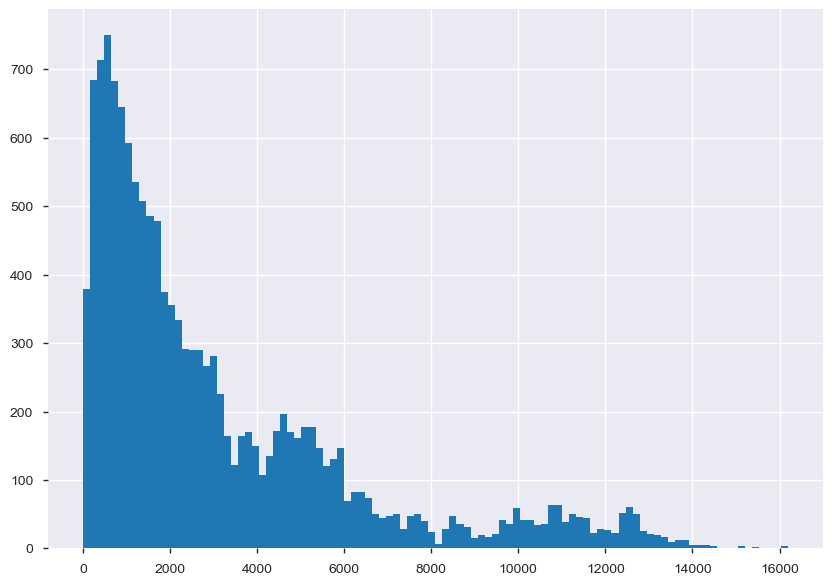

In [30]:
# Распределение относительно самого влиятельного признака

df_train['Ranking'][df_train['Rating'] == 4].hist(bins=100)

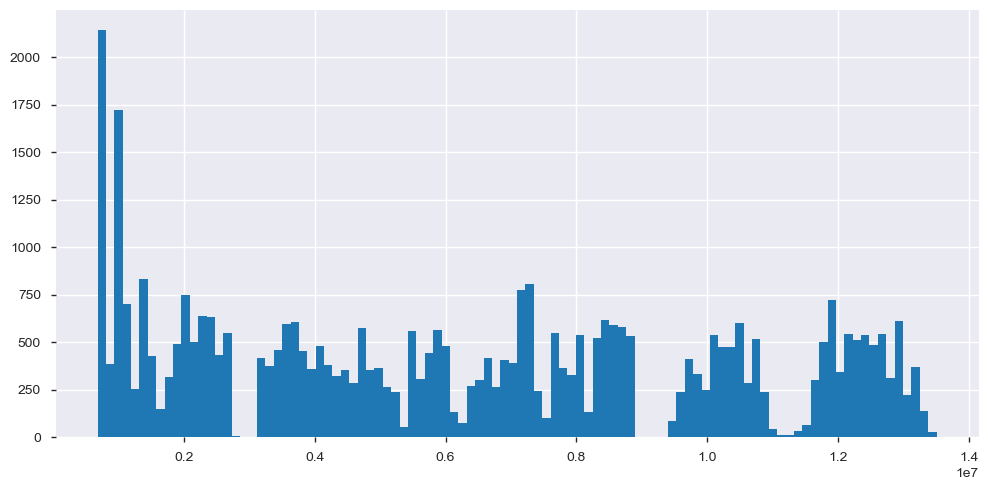

In [31]:
# Посмотрим на распределение признака ID_TA

df_train['ID_TA'].apply(lambda x: x.replace('d','')).astype(int).hist(figsize=(10, 5), bins=100);
plt.tight_layout()



**_Очевидно наличие в признаке ID_TA нескольких групп - на идентификатор это точно не похоже._**

### Внедрение в датасет дополнительных признаков. 
### Избавление от пропусков. 
### Изменение типа данных.

In [32]:
# Превратим данные в столбцах Restaurant_id и ID_TA в числовые данные

data['Restaurant_id'] = data['Restaurant_id'].apply(lambda x: int(x[3:]))
data['ID_TA'] = data['ID_TA'].apply(lambda x: int(x[1:])) 

In [33]:
# Сформируем из внешнего источника множество столиц типа 'primary'

capitals_df = cities.dropna(subset=['capital'])
capitals = set(capitals_df[capitals_df['capital'] == 'primary']['city_ascii'])

In [34]:
# Создадим в датасете дополнительный бинарный столбец is_capital

data['is_capital'] = data['City'].apply(is_capital)

In [35]:
# Сформируем из внешнего источника множества по населению в городах и страновой принадлежности

city_population = cities.set_index('city_ascii').to_dict()['population'] 
city_country = cities.set_index('city_ascii').to_dict()['iso3'] 

In [36]:
# Применим эти словари к данным в столбце City датасета, используя метод map, для создания доп. признаков

data['Population'] = data['City'].map(city_population)
data['Country'] = data['City'].map(city_country)

In [37]:
# Переведем информацию о городах и странах в числовой формат с помощью sklearn.preprocessign.LabelEncoder

le = LabelEncoder()

le.fit(data['City'])
data['City_Decoder'] = le.transform(data['City'])

le.fit(data['Country'])
data['Country_Decoder'] = le.transform(data['Country'])

In [38]:
data.head(3)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,is_capital,Population,Country,City_Decoder,Country_Decoder
0,0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,10746918,0,0.0,True,9904000.0,FRA,23,8
1,1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,6674944,0,0.0,True,1115000.0,FIN,12,7
2,2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,13129638,0,0.0,False,504966.0,GBR,9,9


In [39]:
# Создадим словарь с количеством ресторанов в каждом городе

rest_count = data.groupby('City')['City'].count().sort_values(ascending=False)

In [40]:
# Создадим дополнительный столбец Restaurants Count, с общим количеством ресторанов в каждом городе

data['Restaurants_Count'] = data['City'].map(rest_count)

In [41]:
# Добавим числовой признак Restaurant Per Population с количеством ресторанов на 10 тыс. населения 

data['Restaurant_Per_Population'] = round((data['Restaurants_Count']*10000/data['Population']), 2) 

In [42]:
# Создадим дополнительный столбец с признаком относительности Ranking к числу ресторанов в городе

data['Relative_Ranking'] = round((data['Ranking']/data['Restaurants_Count']), 2)

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 19 columns):
Restaurant_id                50000 non-null int64
City                         50000 non-null object
Cuisine Style                38410 non-null object
Ranking                      50000 non-null float64
Price Range                  32639 non-null object
Number of Reviews            46800 non-null float64
Reviews                      49998 non-null object
URL_TA                       50000 non-null object
ID_TA                        50000 non-null int64
sample                       50000 non-null int64
Rating                       50000 non-null float64
is_capital                   50000 non-null bool
Population                   50000 non-null float64
Country                      50000 non-null object
City_Decoder                 50000 non-null int32
Country_Decoder              50000 non-null int32
Restaurants_Count            50000 non-null int64
Restaurant_Per_Population   

In [44]:
# Сохраним количество пропусков в столбце Cuisine Style

data['Cuisine_Style_isNAN'] = pd.isna(data['Cuisine Style']).astype('float64') 

# Заполним пропуски значением 'Local'

data['Cuisine Style'] = data['Cuisine Style'].fillna("['Local']")


In [45]:
# Проведем обработку значений столбца Cuisine Style

data['Cuisine Style'] = data['Cuisine Style'].str.findall(r"'(\b.*?\b)'") 
temp_list = data['Cuisine Style'].tolist()
temp_counter = Counter(list_unzip(temp_list))

In [46]:
# Создадим дополнительный столбец с признаком количества стилей в ресторане

data['Cuisine_Style_Count'] = data['Cuisine Style'].apply(lambda x: len(x)).astype('float64')

In [47]:
data.sample(3)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,...,is_capital,Population,Country,City_Decoder,Country_Decoder,Restaurants_Count,Restaurant_Per_Population,Relative_Ranking,Cuisine_Style_isNAN,Cuisine_Style_Count
7235,7235,Berlin,[Local],3143.0,NaN,4.0,"[[], []]",/Restaurant_Review-g187323-d9604575-Reviews-La...,9604575,0,...,True,3406000.0,DEU,3,4,2705,7.94,1.16,1.0,1.0
16753,1421,Lyon,"[French, Bar, European, Pub]",1422.0,$$ - $$$,213.0,"[['Very good salad', 'Average brunch'], ['05/1...",/Restaurant_Review-g187265-d4675300-Reviews-Le...,4675300,1,...,False,1423000.0,FRA,18,8,1126,7.91,1.26,0.0,4.0
19421,2800,Vienna,"[Japanese, Sushi, Asian]",2802.0,$,10.0,"[['Good place for Asian food', 'Good place for...",/Restaurant_Review-g190454-d1147122-Reviews-To...,1147122,1,...,True,2400000.0,AUT,28,0,1443,6.01,1.94,0.0,3.0


In [48]:
# Необходимо определиться с данными в столбце Price Range

data['Price Range'].unique()

array(['$$ - $$$', '$$$$', '$', nan], dtype=object)

In [49]:
sum(data['Price Range'].isna())

17361

In [50]:
data['Price Range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

In [51]:
# Перед изменением данных создадим дополнительный бинарный столбец об отсуствии ценовой информации

data['Price_Range_isNAN'] = pd.isna(data['Price Range']).astype('float64') 

In [52]:
# Очевидно, что наиболее часто в датасете встречается средний уровень цен
# Выдвинем гипотезу, что в ресторанах, с отсутствующей по каким-то причинам 
# информацией об уровне цен, также установлен средний уровень цен.

data['Price Range'].fillna('$$ - $$$', inplace=True)

In [53]:
# Переведём столбец Price Range в числовой формат с помощью словаря.

dict_value_Price = {'$':1,'$$ - $$$':2,'$$$$':3}
data['Price Range'] = data['Price Range'].map(lambda x: dict_value_Price.get(x,x))

In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 22 columns):
Restaurant_id                50000 non-null int64
City                         50000 non-null object
Cuisine Style                50000 non-null object
Ranking                      50000 non-null float64
Price Range                  50000 non-null int64
Number of Reviews            46800 non-null float64
Reviews                      49998 non-null object
URL_TA                       50000 non-null object
ID_TA                        50000 non-null int64
sample                       50000 non-null int64
Rating                       50000 non-null float64
is_capital                   50000 non-null bool
Population                   50000 non-null float64
Country                      50000 non-null object
City_Decoder                 50000 non-null int32
Country_Decoder              50000 non-null int32
Restaurants_Count            50000 non-null int64
Restaurant_Per_Population    

In [55]:
# Сохраним количество пропусков в столбце Number of Reviews

data['Number_of_Reviews_isNAN'] = pd.isna(data['Number of Reviews']).astype('float64')

In [56]:
# Заполним пропуски в столбце количества отзывов на основании гипотезы об отсутсвии таковых

data['Number of Reviews'].fillna(0, inplace=True)

### Отзывы

In [58]:
data.Reviews[11]

"[['GREAT APERITIVO WITH STYLE', 'Disappointing'], ['05/16/2015', '02/22/2015']]"

In [59]:
# Предварительный анализ с pandas_profiling показал наличие пропусков в виде пустых списков
# Проведём очистку nan в списках отзывов и их дат на строку с датой по-умолчанию с помощью функции

data['Reviews'] = data['Reviews'].apply(default_changes)    

In [60]:
# Разделим данные в столбце Reviews на собственно отзыв и дату

last_review = []
last_review_date = []
first_review = []
first_review_date = []
for reviews in data['Reviews']:
    reviews_list = get_list(reviews)
    if len(reviews_list) == 2:
        if (len(reviews_list[0]) == 2 and len(reviews_list[1]) == 2):
            last_review.append(reviews_list[0][0])
            last_review_date.append(reviews_list[1][0])
            first_review.append(reviews_list[0][1])
            first_review_date.append(reviews_list[1][1])
        elif (len(reviews_list[0]) == 1 and len(reviews_list[1]) == 1):
            last_review.append(reviews_list[0][0])
            last_review_date.append(reviews_list[1][0])
            first_review.append('None review')
            first_review_date.append('01/01/2000')
        else:
            print(reviews_list)

In [61]:
# Создадим дополнительные столбцы с информацией об отзывах и датах, когда они сделаны

# - последний отмеченный в датасете отзыв
data['Last_Review'] = last_review

# - дата последнего отзыва в датасете
data['Last_Date'] = pd.to_datetime(last_review_date)

# - предпоследний отмеченный в датасете отзыв
data['First_Review'] = first_review

# - дата предпоследнего отзыва в датасете
data['First_Date'] = pd.to_datetime(first_review_date)

In [62]:
# Создадим дополнительные столбцы с информацией о количестве дней между отзывами и к текущей дате

data['Days_Between_Reviews'] = data['Last_Date'] - data['First_Date']
data['Days_Since_Last_Review'] = data['Last_Date'].apply(lambda date: CURRENT_DATE - date)

In [63]:
data.sample(3)


,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,...,Cuisine_Style_isNAN,Cuisine_Style_Count,Price_Range_isNAN,Number_of_Reviews_isNAN,Last_Review,Last_Date,First_Review,First_Date,Days_Between_Reviews,Days_Since_Last_Review
48442,5614,Rome,[Local],5616.0,2,0.0,"[['01/01/2000', '01/01/2000'], ['01/01/2000', ...",/Restaurant_Review-g187791-d11929313-Reviews-T...,11929313,1,...,1.0,1.0,1.0,1.0,01/01/2000,2000-01-01,01/01/2000,2000-01-01,0 days,7618 days
15976,16304,London,"[Fast Food, Healthy, Soups]",16317.0,1,2.0,"[['Severely disappointing', 'A total joke'], [...",/Restaurant_Review-g186338-d11614999-Reviews-C...,11614999,1,...,0.0,3.0,0.0,0.0,Severely disappointing,2017-05-31,A total joke,2016-12-20,162 days,1258 days
14975,805,Rome,[Italian],806.0,2,55.0,"[['01/01/2000', '01/01/2000'], ['01/01/2000', ...",/Restaurant_Review-g187791-d12667565-Reviews-C...,12667565,1,...,0.0,1.0,0.0,0.0,01/01/2000,2000-01-01,01/01/2000,2000-01-01,0 days,7618 days


In [68]:
data['Days_Between_Reviews'] = abs(data['Days_Between_Reviews'].apply(get_days))
data['Days_Since_Last_Review'] = data['Days_Since_Last_Review'].apply(get_days)

In [69]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 29 columns):
Restaurant_id                50000 non-null int64
City                         50000 non-null object
Cuisine Style                50000 non-null object
Ranking                      50000 non-null float64
Price Range                  50000 non-null int64
Number of Reviews            50000 non-null float64
Reviews                      50000 non-null object
URL_TA                       50000 non-null object
ID_TA                        50000 non-null int64
sample                       50000 non-null int64
Rating                       50000 non-null float64
is_capital                   50000 non-null bool
Population                   50000 non-null float64
Country                      50000 non-null object
City_Decoder                 50000 non-null int32
Country_Decoder              50000 non-null int32
Restaurants_Count            50000 non-null int64
Restaurant_Per_Population    

### Корреляция признаков

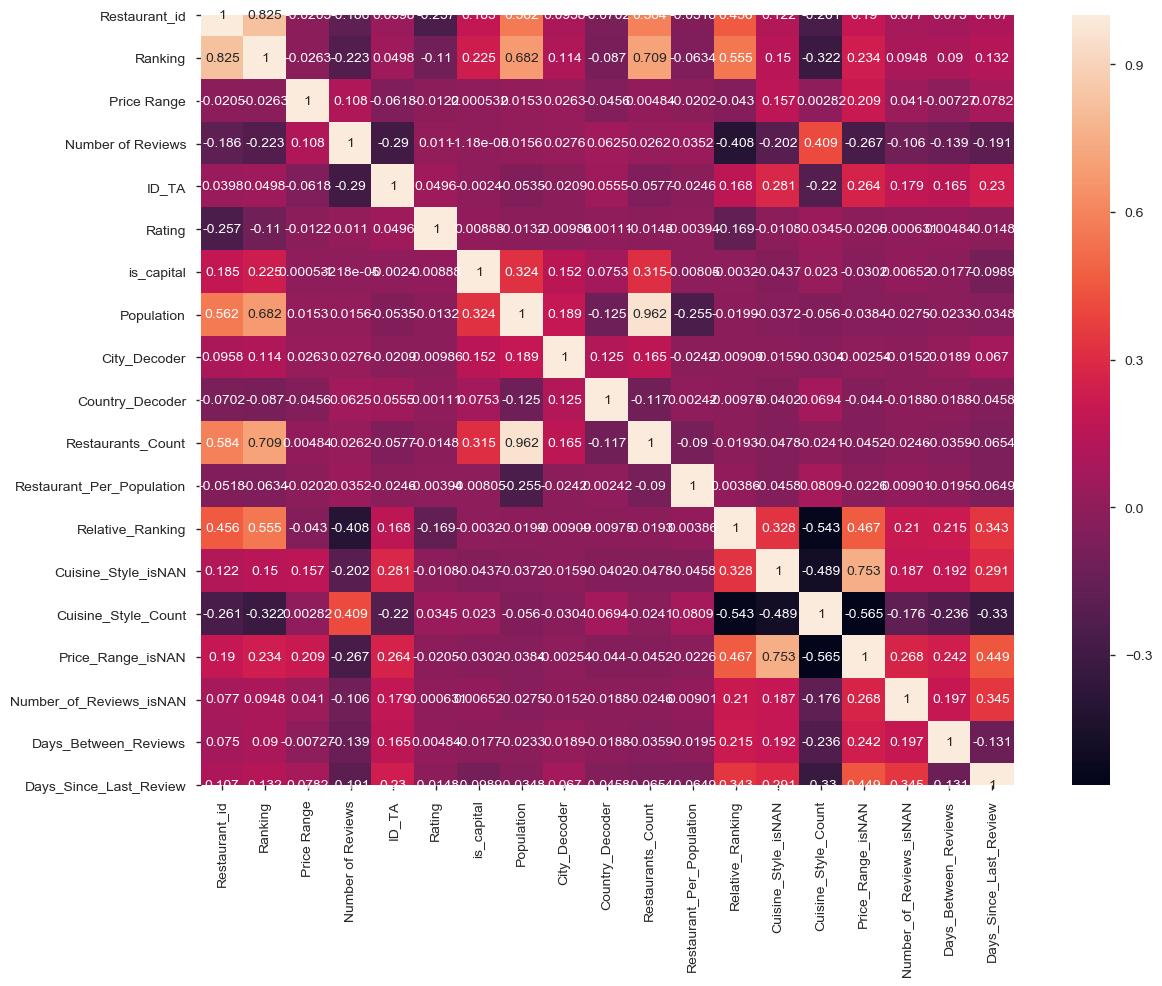

In [70]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot = True, fmt='.3g', square=True)

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [72]:
# См. выше

#### Запускаем и проверяем что получилось

In [82]:
df_preproc = preproc_data(data)
df_preproc.sample(10)

,Restaurant_id,Ranking,Price Range,Number of Reviews,ID_TA,sample,Rating,is_capital,Population,City_Decoder,Country_Decoder,Restaurants_Count,Restaurant_Per_Population,Relative_Ranking,Cuisine_Style_isNAN,Cuisine_Style_Count,Price_Range_isNAN,Number_of_Reviews_isNAN,Days_Between_Reviews,Days_Since_Last_Review
30413,837,838.0,2,43.0,12507482,1,4.5,True,5567000.0,19,6,3813,6.85,0.22,0.0,4.0,0.0,0.0,-170,1211
45737,3369,3370.0,2,90.0,11756512,1,4.0,True,9904000.0,23,8,6108,6.17,0.55,0.0,3.0,0.0,0.0,6,1154
229,229,397.0,3,75.0,1124172,0,0.0,False,756000.0,13,17,554,7.33,0.72,0.0,6.0,0.0,0.0,19,1039
24279,1114,1117.0,2,9.0,2463842,1,2.0,True,835000.0,22,16,488,5.84,2.29,0.0,1.0,1.0,0.0,54,1433
36848,1760,1763.0,1,21.0,7645585,1,4.5,True,2812000.0,14,18,1647,5.86,1.07,0.0,2.0,0.0,0.0,111,1763
34528,1065,1067.0,2,0.0,4082285,1,5.0,True,3242000.0,1,10,776,2.39,1.38,0.0,1.0,1.0,1.0,4881,2737
37192,16324,16339.0,2,6.0,5122964,1,1.0,True,8567000.0,16,9,7193,8.40,2.27,0.0,1.0,1.0,0.0,42,1124
17237,52,53.0,2,1103.0,5122082,1,4.5,True,8567000.0,16,9,7193,8.40,0.01,0.0,5.0,0.0,0.0,3,1036
38865,646,647.0,2,20.0,12787513,1,4.0,False,1423000.0,18,8,1126,7.91,0.57,0.0,2.0,0.0,0.0,0,7618
8045,8045,1143.0,1,25.0,816947,0,0.0,True,3242000.0,1,10,776,2.39,1.47,0.0,2.0,0.0,0.0,411,1521


In [83]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 20 columns):
Restaurant_id                50000 non-null int64
Ranking                      50000 non-null float64
Price Range                  50000 non-null int64
Number of Reviews            50000 non-null float64
ID_TA                        50000 non-null int64
sample                       50000 non-null int64
Rating                       50000 non-null float64
is_capital                   50000 non-null bool
Population                   50000 non-null float64
City_Decoder                 50000 non-null int32
Country_Decoder              50000 non-null int32
Restaurants_Count            50000 non-null int64
Restaurant_Per_Population    50000 non-null float64
Relative_Ranking             50000 non-null float64
Cuisine_Style_isNAN          50000 non-null float64
Cuisine_Style_Count          50000 non-null float64
Price_Range_isNAN            50000 non-null float64
Number_of_Reviews_isNAN 

In [84]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [85]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [86]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 19), (40000, 19), (40000, 18), (32000, 18), (8000, 18))

# Model 
Сам ML

In [87]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [88]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [89]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [91]:
y_pred = list(map(round_rating, y_pred))

In [92]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.

print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.16625


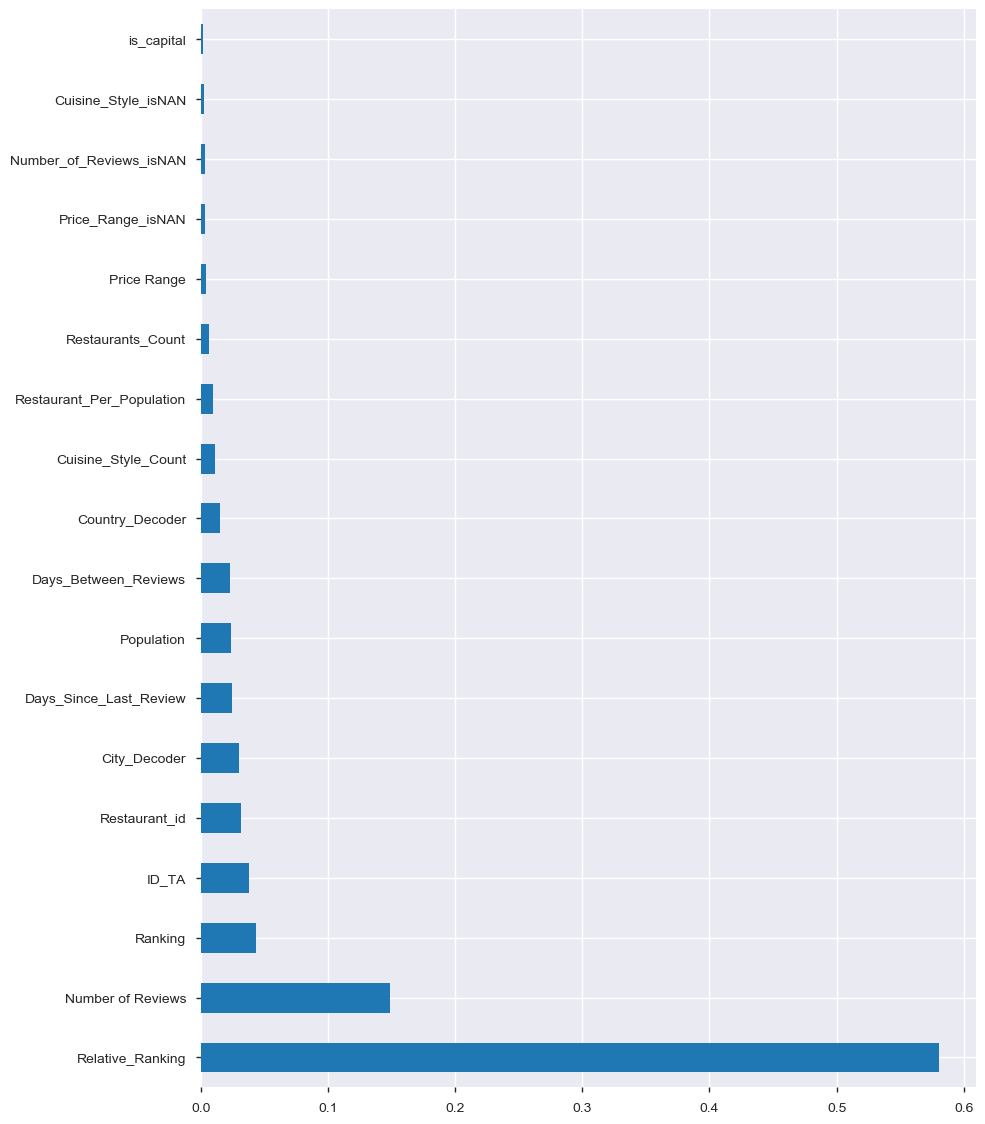

In [93]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели

plt.rcParams['figure.figsize'] = (10,14)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [94]:
test_data.sample(10)

,Restaurant_id,Ranking,Price Range,Number of Reviews,ID_TA,Rating,is_capital,Population,City_Decoder,Country_Decoder,Restaurants_Count,Restaurant_Per_Population,Relative_Ranking,Cuisine_Style_isNAN,Cuisine_Style_Count,Price_Range_isNAN,Number_of_Reviews_isNAN,Days_Between_Reviews,Days_Since_Last_Review
1334,1334,1256.0,2,39.0,5993428,0.0,True,3242000.0,1,10,776,2.39,1.62,0.0,4.0,0.0,0.0,61,1350
8076,8076,2926.0,2,3.0,2357857,0.0,True,1031000.0,0,15,1372,13.31,2.13,1.0,1.0,1.0,0.0,50,1635
7578,7578,3004.0,2,3.0,4209818,0.0,True,1162000.0,25,3,1816,15.63,1.65,0.0,2.0,1.0,0.0,6485,1133
8805,8805,2603.0,1,7.0,10624868,0.0,True,3406000.0,3,4,2705,7.94,0.96,0.0,3.0,0.0,0.0,0,7618
1822,1822,2862.0,2,2.0,7967312,0.0,True,2812000.0,14,18,1647,5.86,1.74,0.0,5.0,1.0,0.0,0,7618
8117,8117,1372.0,2,6.0,10109243,0.0,False,1240000.0,10,2,590,4.76,2.33,1.0,1.0,1.0,0.0,37,1140
3031,3031,8603.0,2,9.0,11800835,0.0,True,9904000.0,23,8,6108,6.17,1.41,1.0,1.0,1.0,0.0,142,1322
7083,7083,2413.0,2,386.0,1016560,0.0,True,3339000.0,26,13,2589,7.75,0.93,0.0,4.0,0.0,0.0,270,1080
1521,1521,509.0,1,52.0,8620982,0.0,False,1337000.0,24,18,642,4.80,0.79,0.0,1.0,0.0,0.0,49,1102
2807,2807,11148.0,2,31.0,7890933,0.0,True,8567000.0,16,9,7193,8.40,1.55,0.0,4.0,0.0,0.0,25,1281


In [95]:
test_data = test_data.drop(['Rating'], axis=1)

In [96]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [97]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [98]:
predict_submission = list(map(round_rating, predict_submission))

In [100]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.5
1,id_1,4.0
2,id_2,4.0
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,3.0
7,id_7,2.5
8,id_8,4.0
9,id_9,4.5


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
